# DoWhy: Different estimation methods for causal inference
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

We will see that not all estimators return the correct effect for this dataset.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False,
        stddev_treatment_noise=10)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.687986,1.633494,-1.250625,0.927178,-1.833909,-0.404578,True,5.498197
1,1.0,0.756570,0.398974,-1.389788,1.146683,-2.245861,-0.845968,True,1.782328
2,1.0,0.875724,-1.170325,-0.138730,2.203882,-0.030699,-1.603035,True,4.628401
3,0.0,0.924126,-0.951097,0.675440,0.480698,-0.861801,-2.738749,False,-12.592867
4,0.0,0.605515,-0.342407,1.448468,1.408716,-2.028318,-0.414919,True,13.333022
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.056583,-0.011412,-3.570399,1.246381,-0.298294,-2.293432,False,-21.295866
9996,1.0,0.504050,-0.747385,-0.053360,0.117537,-1.425899,-1.864726,False,-11.462042
9997,1.0,0.904261,0.228929,-1.418597,0.218014,-0.802668,-0.169217,True,4.449252
9998,1.0,0.380770,-0.407239,0.672763,2.566541,-2.290793,0.009718,True,15.038049


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

In [5]:
model.view_model()

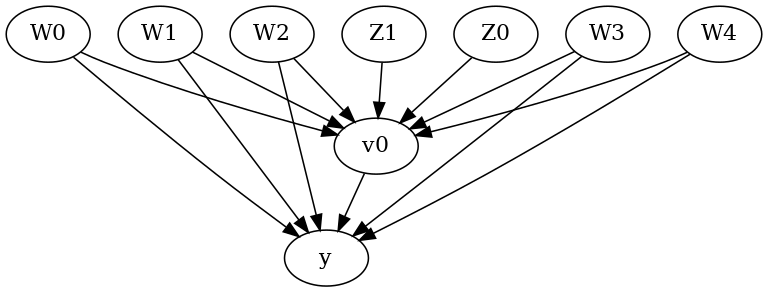

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Method 1: Regression

Use linear regression.

In [8]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W4+W3+W0+W1+W2
Target units: ate

## Estimate
Mean value: 10.00004796011746
p-value: [0.]

Causal Estimate is 10.00004796011746


## Method 2: Distance Matching

Define a distance metric and then use the metric to match closest points between treatment and control.

In [9]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W4+W3+W0+W1+W2
Target units: att

## Estimate
Mean value: 10.500365546485488

Causal Estimate is 10.500365546485488


## Method 3: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [10]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W4+W3+W0+W1+W2
Target units: att

## Estimate
Mean value: 10.091725925183123

Causal Estimate is 10.091725925183123


## Method 4: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [11]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W4+W3+W0+W1+W2
Target units: atc

## Estimate
Mean value: 9.850957370560343

Causal Estimate is 9.850957370560343


## Method 5: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [12]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W0,W1,W2,U) = P(y|v0,W4,W3,W0,W1,W2)

## Realized estimand
b: y~v0+W4+W3+W0+W1+W2
Target units: ate

## Estimate
Mean value: 10.184880436277249

Causal Estimate is 10.184880436277249


## Method 6: Instrumental Variable

We will be using the Wald estimator for the provided instrumental variable.

In [13]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡ d    ⎤  -1⎡ d     ⎤
E⎢───(y)⎥⋅E  ⎢───(v₀)⎥
 ⎣dZ₀   ⎦    ⎣dZ₀    ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same wa

## Method 7: Regression Discontinuity

We will be internally converting this to an equivalent instrumental variables problem.

In [14]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.15})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡        d            ⎤  -1⎡        d             ⎤
E⎢──────────────────(y)⎥⋅E  ⎢──────────────────(v₀)⎥
 ⎣dlocal_rd_variable   ⎦    ⎣dlocal_rd_variable    ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_t